# 🔧 环境配置和检查

## 概述
本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：
- 使用统一的conda环境
- 通过国内镜像源快速安装依赖
- 加速模型下载
- 检查系统配置

## 配置步骤
1. **Conda环境管理** - 激活统一的学习环境
2. **包管理器优化** - 配置pip使用清华镜像源
3. **模型下载加速** - 设置HuggingFace镜像代理
4. **系统环境诊断** - 检查硬件和软件配置


In [ ]:
# 1. 激活conda环境
%%script bash
# 初始化 conda
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action
conda env list


In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-5/memoryschema_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基于用户档案模式(Schema)的聊天机器人


核心目标是将之前的简单字符串记忆升级为一个结构化的 **用户档案 (user profile)**，并利用 **Trustcall** 库来管理和更新这个档案。

---

### **大模型聊天机器人中的记忆机制：从字符串到结构化档案**

在构建一个能够进行有意义对话的聊天机器人时，让它记住用户的信息至关重要。这通常涉及到两种类型的记忆：

1.  **短期记忆 (Short-Term Memory)**：也称为“会话记忆”或“上下文记忆”。它存储了当前对话线程中的信息。举例来说，当您问“巴黎的天气怎么样？”然后立即问“那伦敦呢？”，机器人需要记住“伦敦”是与“天气”相关的。这种记忆通常在对话结束后就会被清除。
    
2.  **长期记忆 (Long-Term Memory)**：也称为“跨会话记忆”。它允许机器人在不同的对话之间记住关于用户的信息。例如，如果您告诉机器人您最喜欢的颜色是蓝色，它应该在下一次与您聊天时也能记住这一点。这正是 **LangGraph Memory Store** 的用途。
    
---

### **从简单字符串记忆到结构化档案的演变**

之前我们实现的机器人只是简单地将事实（例如“用户的名字是小明”）作为**字符串**存储起来。这种方式虽然简单，但效率低下且难以管理。

**存在的问题**：

-   **缺乏结构**：所有信息都混在一起，难以快速提取特定信息。比如，要找到用户的年龄，可能需要扫描一长串文本。
-   **难以更新**：如果需要更新用户的某个信息，比如名字，就必须找到并替换字符串中的那一部分，这很容易出错。

---

### **引入“用户档案”和 Trustcall 库**

为了解决这些问题，我们的目标是将记忆转化为一个**单一的、持续更新的结构化档案**，即“用户档案”。这个档案就像一个数据库记录，其中包含了一系列字段，例如：

-   **姓名**：`string`
-   **年龄**：`number`
-   **城市**：`string`
-   **兴趣爱好**：`list of strings`

这个用户档案提供了清晰的结构，让机器人可以快速访问和修改特定信息。

为了自动化地更新这个复杂的结构，我们将引入一个名为 **Trustcall** 的库。

**Trustcall 的作用**：

当用户在对话中提到新的信息（例如“我的生日是1995年1月1日”），**Trustcall** 会利用其能力，识别出这些信息，并根据预定义的档案模式，**自动地**将其解析并更新到相应的字段中，而不是简单地将整个句子作为字符串存储。

这种方法被称为“在热路径（in the hot path）中存储记忆”，意味着在用户与机器人实时对话的过程中，记忆就被立即、有结构地更新和保存下来。

---

### **总结**

这个项目旨在展示一个更高级的记忆管理方法：

1.  **将记忆从无结构的字符串升级为有结构的**用户档案**。**
2.  **利用** LangGraph Memory Store **实现跨会话的长期记忆。**
3.  **使用** Trustcall **库自动化档案的更新，从而在实时对话中高效地保存新的用户事实。**

这不仅让机器人能更可靠地记住用户，也为开发者提供了一种更高效、更可扩展的方式来管理和利用这些记忆。

---

## 回顾

我们介绍了 [LangGraph 内存存储](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) 作为保存和检索长期记忆的一种方式。

我们构建了一个简单的聊天机器人，它同时使用 `短期记忆（线程内）` 和 `长期记忆（跨线程）`。

它保存了长期 [语义记忆](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory)（关于用户的事实信息）["在热路径中"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories)，即用户与机器人聊天时。

## 目标

我们的聊天机器人将记忆保存为字符串。在实践中，我们通常希望记忆具有结构。

例如，记忆可以是一个 [单一的、持续更新的模式(Schema)](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)。

在我们的案例中，我们希望这是一个单一的用户档案。

我们将扩展我们的聊天机器人，将语义记忆保存到单个 [用户档案](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) 中。

我们还将介绍一个库 [Trustcall](https://github.com/hinthornw/trustcall)，用于使用新信息更新这个模式(Schema)。

## 技术背景

**什么是结构化记忆？**
- 传统上，聊天机器人的记忆是简单的文本字符串
- 结构化记忆使用预定义的数据模式(Schema)来组织信息
- 这使得记忆更加可预测、可查询和可维护

**为什么需要用户档案模式(Schema)？**
- 提供一致的用户信息存储格式
- 便于在不同会话间保持用户偏好
- 支持更智能的个性化响应



> 通俗来说，Schema 就像一张蓝图。

> 它定义了数据的结构和组织方式，而不是具体的数据内容。

> 举个简单的例子，假设我们要记录一个人的信息：

> Schema 就是这张“信息表”的设计图。它会规定表里有哪些列（比如：姓名、年龄、城市），每列的数据类型是什么（姓名是文本，年龄是数字），以及这些列的排列顺序。

> 实际数据才是具体的内容，比如：张三，30，北京。这些具体内容必须严格遵守 Schema 的规定。你不能在“年龄”那一栏填入“二十岁”这样的文本，因为 Schema 规定它必须是数字。

> 所以，Schema 的核心作用是提供规则和约束，确保数据的一致性和有效性。



In [ ]:
# 安装必要的依赖包
# 这些包是构建基于用户档案的聊天机器人所必需的
%%capture --no-stderr
# %pip install -U langchain_openai langgraph trustcall langchain_core
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 trustcall==0.0.39

In [ ]:
import os, getpass

def _set_env(var: str):
    """
    设置环境变量的辅助函数

    参数:
        var (str): 环境变量名称
    """
    # 检查环境变量是否已在操作系统中设置
    env_value = os.environ.get(var)
    if not env_value:
        # 如果未设置，提示用户输入
        env_value = getpass.getpass(f"{var}: ")

    # 为当前进程设置环境变量
    os.environ[var] = env_value

# 设置 LangSmith API 密钥用于追踪和监控
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"  # 启用追踪功能
os.environ["LANGSMITH_PROJECT"] = "FlyAIBox"  # 设置项目名称

LANGSMITH_API_KEY: ··········


## 定义用户档案模式(Schema)

Python 有多种不同的 [结构化数据](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition) 类型，如 TypedDict、字典、JSON 和 [Pydantic](https://docs.pydantic.dev/latest/)。

让我们从使用 TypedDict 定义用户档案模式(Schema)开始。

### 什么是模式(Schema)？
- **模式(Schema)** 是数据的结构定义，类似于数据库表结构
- 它定义了数据应该包含哪些字段以及每个字段的类型
- 在聊天机器人中，模式(Schema)帮助我们以一致的方式存储和检索用户信息

### TypedDict vs Pydantic
- **TypedDict**: Python 内置，轻量级，主要用于类型提示
- **Pydantic**: 功能更强大，支持数据验证、序列化等高级功能

In [ ]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """
    用户档案模式(Schema)，包含类型化的字段

    这个类定义了用户档案的基本结构，包含用户名和兴趣列表
    使用 TypedDict 确保类型安全，同时保持字典的灵活性
    """
    user_name: str  # 用户的首选名称
    interests: List[str]  # 用户兴趣列表

## 将模式(Schema)保存到存储中

[LangGraph 存储](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) 接受任何 Python 字典作为 `value`。

### 存储系统的工作原理
- **命名空间（Namespace）**: 用于组织和隔离不同用户的数据
- **键（Key）**: 在命名空间内唯一标识特定数据的标识符
- **值（Value）**: 实际存储的数据，可以是任何 Python 对象

In [ ]:
# 创建 TypedDict 实例
# 这里我们创建一个具体的用户档案示例
user_profile: UserProfile = {
    "user_name": "FLY",
    "interests": ["骑自行车", "技术", "咖啡"]
}
user_profile

{'user_name': 'FLY', 'interests': ['骑自行车', '技术', '咖啡']}

我们使用 [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) 方法将 TypedDict 保存到存储中。

### put 方法详解
- **功能**: 将数据存储到指定的命名空间和键下
- **参数**:
  - `namespace`: 命名空间元组，用于组织数据
  - `key`: 数据键，在命名空间内唯一
  - `value`: 要存储的数据对象

In [ ]:
import uuid
from langgraph.store.memory import InMemoryStore

# 初始化内存存储
# InMemoryStore 是一个简单的内存存储实现，适合演示和开发
in_memory_store = InMemoryStore()

# 为要保存的记忆设置命名空间
# 命名空间格式: (用户ID, 记忆类型)
user_id = "1"
namespace_for_memory = (user_id, "memory")

# 将记忆保存到命名空间，使用键值对存储
key = "user_profile"  # 在命名空间内的唯一标识符
value = user_profile  # 要存储的用户档案数据
in_memory_store.put(namespace_for_memory, key, value)

我们使用 [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) 方法通过命名空间从存储中检索对象。

### search 方法详解
- **功能**: 搜索指定命名空间下的所有对象
- **返回**: 包含匹配对象的迭代器
- **用途**: 查看命名空间内存储的所有数据

In [ ]:
# 搜索并显示存储的数据
# 遍历命名空间中的所有对象并打印其详细信息
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'FLY', 'interests': ['骑自行车', '技术', '咖啡']}, 'created_at': '2025-09-17T08:59:13.224498+00:00', 'updated_at': '2025-09-17T08:59:13.224501+00:00', 'score': None}


我们也可以使用 [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) 方法通过命名空间和键检索特定对象。

### get 方法详解
- **功能**: 根据命名空间和键精确检索单个对象
- **参数**:
  - `namespace`: 命名空间元组
  - `key`: 对象键
- **返回**: 包含对象数据的存储项
- **用途**: 快速获取特定的用户档案数据

In [ ]:
# 通过命名空间和键获取记忆
# 精确检索特定的用户档案数据
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value  # 获取存储项的值部分

{'user_name': 'FLY', 'interests': ['骑自行车', '技术', '咖啡']}

## 基于档案模式(Schema)的聊天机器人

现在我们知道如何为记忆指定模式(Schema)并将其保存到存储中。

但是，我们如何实际使用这个特定模式(Schema)*创建*记忆呢？

在我们的聊天机器人中，我们 [希望从用户聊天中创建记忆](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)。

这就是 [结构化输出](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 概念发挥作用的地方。

LangChain 的 [聊天模型](https://python.langchain.com/docs/concepts/chat_models/) 接口有一个 [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 方法来强制结构化输出。

当我们希望确保输出符合模式(Schema)并为我们解析输出时，这非常有用。

### 什么是结构化输出？
- **定义**: 确保 AI 模型输出符合预定义格式的技术
- **优势**:
  - 保证数据格式一致性
  - 便于后续处理和存储
  - 减少解析错误
- **实现**: 通过 `with_structured_output` 方法将模式(Schema)绑定到模型

In [ ]:
# 设置OpenAI API密钥
# 您需要从 https://api.apiyi.com/v1 获取API密钥
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


让我们将创建的 `UserProfile` 模式(Schema)传递给 `with_structured_output` 方法。

然后我们可以使用 [消息](https://python.langchain.com/docs/concepts/messages/) 列表调用聊天模型，并获得符合我们模式(Schema)的结构化输出。

### 工作流程
1. **模式(Schema)绑定**: 将用户档案模式(Schema)绑定到聊天模型
2. **消息输入**: 提供用户对话消息
3. **结构化输出**: 模型返回符合模式(Schema)的用户档案数据
4. **数据验证**: 自动确保输出格式正确

In [ ]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# 初始化聊天模型
# 使用 GPT-4o 模型，temperature=0 确保输出稳定
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 将模式(Schema)绑定到模型
# 这确保模型输出符合 UserProfile 模式(Schema)
model_with_structure = model.with_structured_output(UserProfile)

# 调用模型生成符合模式(Schema)的结构化输出
# 输入用户消息，输出结构化的用户档案
structured_output = model_with_structure.invoke([HumanMessage("我是FLY，我喜欢骑自行车。")])
structured_output

{'user_name': 'FLY', 'interests': ['骑自行车']}

现在，让我们在聊天机器人中使用这个功能。

这只需要对 `write_memory` 函数进行少量修改。

我们使用上面定义的 `model_with_structure` 来生成符合我们模式(Schema)的档案。

### 集成步骤
1. **修改记忆写入函数**: 使用结构化输出模型
2. **保持现有逻辑**: 其他部分保持不变
3. **确保数据一致性**: 输出始终符合预定义模式(Schema)

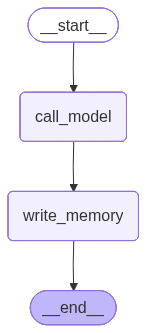

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# 聊天机器人系统指令
# 定义机器人的角色和行为规范，并说明如何利用用户记忆来个性化回复。
MODEL_SYSTEM_MESSAGE = """你是一个有帮助的助手，具有记忆功能，可以提供关于用户的信息。
如果你有这个用户的记忆，请使用它来个性化你的回复。
以下是记忆（可能为空）：{memory}"""

# 从聊天历史和任何现有记忆中创建/更新新记忆的指令
# 这个指令用于指导模型如何根据当前对话和现有用户档案来生成或更新用户记忆。
CREATE_MEMORY_INSTRUCTION = """根据用户的聊天历史创建或更新用户档案记忆。
这将保存为长期记忆。如果存在现有记忆，只需更新它。
以下是现有记忆（可能为空）：{memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    从存储中加载用户档案记忆并使用它来个性化聊天机器人的回复。

    参数:
        state: 消息状态，一个字典，包含当前对话的完整历史消息列表。
        config: 运行配置，一个字典，通常包含用于标识用户或线程的信息，例如用户ID。
        store: 存储接口，一个 BaseStore 的实例，用于访问和管理长期记忆数据。

    返回:
        包含AI回复消息的字典。返回的消息列表将追加到当前状态中。
    """

    # 从配置字典中安全地获取用户ID。
    user_id = config["configurable"]["user_id"]

    # 定义用于存储用户记忆的命名空间。命名空间有助于组织和隔离不同用户的数据。
    namespace = ("memory", user_id)
    # 从存储中检索特定用户的记忆。使用 "user_memory" 作为键来获取用户档案。
    existing_memory = store.get(namespace, "user_memory")

    # 格式化现有记忆以便在系统提示中使用。如果记忆存在且有值，则提取并格式化姓名和兴趣。
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"姓名: {memory_dict.get('user_name', '未知')}\n" # 如果 user_name 不存在，则显示“未知”
            f"兴趣: {', '.join(memory_dict.get('interests', []))}" # 将兴趣列表转换为逗号分隔的字符串
        )
    else:
        # 如果没有找到现有记忆，则格式化记忆为 None。
        formatted_memory = None

    # 使用格式化后的记忆来构建完整的系统提示消息。
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # 调用语言模型生成回复。输入包括系统消息和当前的聊天历史。
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    # 返回包含AI回复消息的字典，以便更新状态。
    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    反思聊天历史，利用模型生成或更新用户档案记忆，并将其保存到存储中。

    参数:
        state: 消息状态，包含当前对话的完整历史消息列表。
        config: 运行配置，通常包含用户ID等信息。
        store: 存储接口，用于访问和管理长期记忆数据。
    """

    # 从配置字典中获取用户ID。
    user_id = config["configurable"]["user_id"]

    # 定义用于存储用户记忆的命名空间。
    namespace = ("memory", user_id)
    # 从存储中检索现有用户的记忆。
    existing_memory = store.get(namespace, "user_memory")

    # 格式化现有记忆以便在指令中使用。如果记忆存在且有值，则提取并格式化姓名和兴趣。
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"姓名: {memory_dict.get('user_name', '未知')}\n" # 如果 user_name 不存在，则显示“未知”
            f"兴趣: {', '.join(memory_dict.get('interests', []))}" # 将兴趣列表转换为逗号分隔的字符串
        )
    else:
        # 如果没有找到现有记忆，则格式化记忆为 None。
        formatted_memory = None

    # 使用格式化后的现有记忆来构建指令消息，指导模型如何创建或更新记忆。
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # 调用带有结构化输出的模型来生成符合 UserProfile 模式(Schema)的新记忆。
    # 输入包括指令消息和当前的聊天历史。
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # 将新生成的或更新后的用户档案记忆保存到存储中。使用 "user_memory" 作为键。
    key = "user_memory"
    store.put(namespace, key, new_memory)

# 定义 LangGraph 的状态图。
# StateGraph 定义了节点（图中的步骤）和边（节点之间的转换）。
builder = StateGraph(MessagesState)
# 添加 "call_model" 节点，对应上面定义的 call_model 函数。
builder.add_node("call_model", call_model)  # 调用语言模型生成回复
# 添加 "write_memory" 节点，对应上面定义的 write_memory 函数。
builder.add_node("write_memory", write_memory)  # 写入/更新用户档案记忆
# 定义从图的开始到 "call_model" 节点的边。
builder.add_edge(START, "call_model")  # 对话开始时，首先调用模型生成回复
# 定义从 "call_model" 节点到 "write_memory" 节点的边。
builder.add_edge("call_model", "write_memory")  # 模型生成回复后，根据对话更新记忆
# 定义从 "write_memory" 节点到图的结束的边。
builder.add_edge("write_memory", END)  # 记忆更新完成后，流程结束

# 初始化长期记忆存储（跨线程）。
# InMemoryStore 是一个简单的内存存储实现，数据存储在内存中，适合开发和演示。
across_thread_memory = InMemoryStore()

# 初始化短期记忆检查点（线程内）。
# MemorySaver 检查点将线程的状态保存在内存中，用于在同一线程内恢复对话。
within_thread_memory = MemorySaver()

# 编译图。
# 将构建器、短期记忆检查点和长期记忆存储结合起来，形成一个可执行的图。
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# 显示图结构。
# 使用 mermaid 格式绘制图的可视化表示，帮助理解图的流程。
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# 我们提供线程ID用于短期记忆（线程内）
# 我们提供用户ID用于长期记忆（跨线程）
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 用户输入
# 用户介绍自己的姓名和兴趣
input_messages = [HumanMessage(content="嗨，我是FLY，我喜欢在湖边骑自行车，并在咖啡店喝东西。")]

# 运行图
# 流式处理用户输入并显示AI回复
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

嗨，我是FLY，我喜欢在湖边骑自行车，并在咖啡店喝东西。
================================== Ai Message ==================================

嗨，FLY！很高兴认识你！湖边骑自行车听起来非常惬意，尤其是能感受到自然的气息。之后再去咖啡店喝点东西放松一下，真是完美的搭配！你有特别喜欢的咖啡或者饮品吗？


让我们检查存储中的记忆。

我们可以看到记忆是一个符合我们模式(Schema)的字典。

### 记忆存储验证
- **数据结构**: 记忆以字典形式存储，包含用户档案信息
- **模式(Schema)一致性**: 确保存储的数据符合预定义的 UserProfile 模式(Schema)
- **持久性**: 记忆在会话间保持，支持个性化体验

In [ ]:
# 用于保存记忆的命名空间
user_id = "1"
namespace = ("memory", user_id)
# 从跨线程记忆中获取现有记忆
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value  # 显示记忆的实际内容

{'user_name': 'FLY', 'interests': ['湖边骑自行车', '在咖啡店喝东西']}

## 什么时候会失败？

[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 非常有用，但如果我们在处理更复杂的模式(Schema)时会发生什么？

[这里](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) 是一个更复杂模式(Schema)的示例，我们将在下面测试。

这是一个 [Pydantic](https://docs.pydantic.dev/latest/) 模型，描述了用户在通信和信任跌落方面的偏好。

### 复杂模式(Schema)的挑战
- **嵌套结构**: 多层嵌套的对象和数组
- **可选字段**: 许多字段可能为空或未定义
- **类型验证**: 严格的类型检查可能导致解析失败
- **模型容量**: 即使是 GPT-4o 这样的高级模型也可能遇到困难

In [ ]:
from typing import List, Optional

class OutputFormat(BaseModel):
    """输出格式模式(Schema)，包含偏好和句子偏好显示"""
    preference: str  # 用户偏好
    sentence_preference_revealed: str  # 句子偏好显示

class TelegramPreferences(BaseModel):
    """电报偏好模式(Schema)"""
    preferred_encoding: Optional[List[OutputFormat]] = None  # 首选编码方式
    favorite_telegram_operators: Optional[List[OutputFormat]] = None  # 喜欢的电报操作员
    preferred_telegram_paper: Optional[List[OutputFormat]] = None  # 首选电报纸张

class MorseCode(BaseModel):
    """摩尔斯电码偏好模式(Schema)"""
    preferred_key_type: Optional[List[OutputFormat]] = None  # 首选键类型
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None  # 喜欢的摩尔斯缩写

class Semaphore(BaseModel):
    """旗语偏好模式(Schema)"""
    preferred_flag_color: Optional[List[OutputFormat]] = None  # 首选旗帜颜色
    semaphore_skill_level: Optional[List[OutputFormat]] = None  # 旗语技能水平

class TrustFallPreferences(BaseModel):
    """信任跌落偏好模式(Schema)"""
    preferred_fall_height: Optional[List[OutputFormat]] = None  # 首选跌落高度
    trust_level: Optional[List[OutputFormat]] = None  # 信任水平
    preferred_catching_technique: Optional[List[OutputFormat]] = None  # 首选接住技巧

class CommunicationPreferences(BaseModel):
    """通信偏好模式(Schema)"""
    telegram: TelegramPreferences  # 电报偏好
    morse_code: MorseCode  # 摩尔斯电码偏好
    semaphore: Semaphore  # 旗语偏好

class UserPreferences(BaseModel):
    """用户偏好模式(Schema)"""
    communication_preferences: CommunicationPreferences  # 通信偏好
    trust_fall_preferences: TrustFallPreferences  # 信任跌落偏好

class TelegramAndTrustFallPreferences(BaseModel):
    """电报和信任跌落偏好模式(Schema)"""
    pertinent_user_preferences: UserPreferences  # 相关用户偏好

## 使用 TrustCall 创建和更新档案模式(Schema)

正如我们所看到的，处理模式(Schema)可能很棘手。

复杂的模式(Schema)可能难以提取。

此外，更新即使是简单的模式(Schema)也可能带来挑战。

考虑我们上面的聊天机器人。

我们每次选择保存新记忆时都*从头开始*重新生成档案模式(Schema)。

这是低效的，如果模式(Schema)包含大量信息需要每次都重新生成，可能会浪费模型令牌。

更糟糕的是，从头重新生成档案时我们可能会丢失信息。

解决这些问题是 [TrustCall](https://github.com/hinthornw/trustcall) 的动机！

这是一个开源库，用于更新 JSON 模式(Schema)，由 LangChain 团队的 [Will Fu-Hinthorn](https://github.com/hinthornw) 开发。

它正是为了解决在处理记忆时遇到的这些挑战而创建的。

让我们首先展示 TrustCall 在这个 [消息](https://python.langchain.com/docs/concepts/messages/) 列表上的简单提取用法。

### TrustCall 的优势
- **增量更新**: 只更新模式(Schema)中发生变化的部分
- **效率提升**: 减少模型令牌使用和计算成本
- **信息保持**: 避免在更新过程中丢失现有信息
- **复杂模式(Schema)支持**: 更好地处理嵌套和复杂的模式(Schema)结构


In [ ]:
# 对话示例
# 创建一个简单的对话历史用于演示 TrustCall 的提取功能
conversation = [HumanMessage(content="嗨，我是FLY。"),
                AIMessage(content="很高兴认识你，FLY。"),
                HumanMessage(content="我真的很喜欢在湖边骑自行车。")]

我们使用 `create_extractor`，传入模型以及我们的模式(Schema)作为 [工具](https://python.langchain.com/docs/concepts/tools/)。

使用 TrustCall，可以以各种方式提供模式(Schema)。

例如，我们可以传递 JSON 对象 / Python 字典或 Pydantic 模型。

在底层，TrustCall 使用 [工具调用](https://python.langchain.com/docs/concepts/tool_calling/) 从 [消息](https://python.langchain.com/docs/concepts/messages/) 输入列表生成 [结构化输出](https://python.langchain.com/docs/concepts/structured_outputs/)。

要强制 TrustCall 生成 [结构化输出](https://python.langchain.com/docs/concepts/structured_outputs/)，我们可以在 `tool_choice` 参数中包含模式(Schema)名称。

我们可以使用上面的对话调用提取器。

### TrustCall 工作原理
- **工具调用机制**: 利用 LangChain 的工具调用功能
- **模式(Schema)灵活性**: 支持多种模式(Schema)定义方式
- **强制输出**: 通过 tool_choice 确保特定工具被使用
- **消息处理**: 直接处理消息列表，无需额外格式化

In [ ]:
from trustcall import create_extractor

# 用户档案模式(Schema)定义
class UserProfile(BaseModel):
    """用户档案模式(Schema)，包含类型化字段"""
    user_name: str = Field(description="用户的首选名称")
    interests: List[str] = Field(description="用户兴趣列表")

# 初始化模型
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 创建提取器
# 使用 TrustCall 创建结构化数据提取器
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],  # 将模式(Schema)作为工具传递
    tool_choice="UserProfile"  # 强制使用 UserProfile 工具
)

# 系统指令
system_msg = "从以下对话中提取用户档案"

# 调用提取器
# 传入系统消息和对话历史
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

当我们调用提取器时，我们会得到几个东西：

* `messages`: 包含工具调用的 `AIMessages` 列表。
* `responses`: 符合我们模式(Schema)的解析后工具调用结果。
* `response_metadata`: 如果更新现有工具调用则适用。它说明哪些响应对应于哪些现有对象。

### 提取结果解析
- **messages**: 包含 AI 模型生成的原始工具调用消息
- **responses**: 解析后的结构化数据，可直接使用
- **response_metadata**: 用于跟踪更新操作的元数据


In [ ]:
# 显示提取器生成的原始消息
# 这些消息包含工具调用的详细信息
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_1MPXHKhnINY1LapCneFetCIy)
 Call ID: call_1MPXHKhnINY1LapCneFetCIy
  Args:
    user_name: FLY
    interests: ['骑自行车', '湖边活动']


In [ ]:
# 获取解析后的结构化数据
# 这是可以直接使用的用户档案对象
schema = result["responses"]
schema

[UserProfile(user_name='FLY', interests=['骑自行车', '湖边活动'])]

In [ ]:
# 将 Pydantic 模型转换为字典格式
# 便于查看和进一步处理
schema[0].model_dump()

{'user_name': 'FLY', 'interests': ['骑自行车', '湖边活动']}

In [ ]:
# 查看响应元数据
# 包含工具调用的 ID 和相关信息
result["response_metadata"]

[{'id': 'call_1MPXHKhnINY1LapCneFetCIy'}]

让我们看看如何使用它来*更新*档案。

对于更新，TrustCall 接受一组消息以及现有模式(Schema)。

核心思想是它提示模型生成 [JSON Patch](https://jsonpatch.com/) 来仅更新模式(Schema)的相关部分。

这比天真地覆盖整个模式(Schema)更不容易出错。

它也更高效，因为模型只需要生成已更改的模式(Schema)部分。

我们可以将现有模式(Schema)保存为字典。

我们可以使用 `model_dump()` 将 Pydantic 模型实例序列化为字典。

我们将其与模式(Schema)名称 `UserProfile` 一起传递给 `"existing"` 参数。

### 增量更新机制
- **JSON Patch**: 只修改发生变化的数据部分
- **错误减少**: 避免完全重写可能导致的错误
- **效率提升**: 减少模型需要处理的数据量
- **信息保持**: 保留未更改的现有信息

In [ ]:
# 更新对话
# 添加更多关于用户兴趣的信息
updated_conversation = [HumanMessage(content="嗨，我是FLY。"),
                AIMessage(content="很高兴认识你，FLY。"),
                HumanMessage(content="我真的很喜欢在湖边骑自行车。"),
                AIMessage(content="湖边骑自行车很棒！骑完自行车后你会去哪里"),
                HumanMessage(content="骑完自行车后我喜欢去一家咖啡店。"),]

# 更新指令
# 指示模型更新现有记忆而不是创建新记忆
system_msg = f"""更新记忆（JSON 文档）以整合以下对话中的新信息"""

# 使用更新后的指令和现有档案调用提取器
# 传入现有档案数据以进行增量更新
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation},
                                    {"existing": {"UserProfile": schema[0].model_dump()}})

In [ ]:
# 显示更新后的工具调用消息
# 查看模型如何更新现有档案
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_NLG5rSbZoopxtJX36LsfQklG)
 Call ID: call_NLG5rSbZoopxtJX36LsfQklG
  Args:
    user_name: FLY
    interests: ['湖边骑自行车', '去咖啡店']


In [ ]:
# 查看更新操作的元数据
# 显示哪些响应对应哪些现有对象
result["response_metadata"]

[{'id': 'call_NLG5rSbZoopxtJX36LsfQklG'}]

In [ ]:
# 获取更新后的档案
# 这是包含新信息的完整用户档案
updated_schema = result["responses"][0]
updated_schema.model_dump()  # 转换为字典格式查看

{'user_name': 'FLY', 'interests': ['湖边骑自行车', '去咖啡店']}

## 基于档案模式(Schema)更新的聊天机器人

现在，让我们将 TrustCall 集成到我们的聊天机器人中，以创建*和更新*记忆档案。

### 集成 TrustCall 的优势
- **智能更新**: 只更新发生变化的部分，保持现有信息
- **效率提升**: 减少模型令牌使用和计算成本
- **错误减少**: 避免完全重写可能导致的错误
- **复杂模式(Schema)支持**: 更好地处理嵌套和复杂的用户档案结构

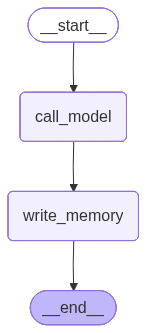

In [ ]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# 初始化模型
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 用户档案模式(Schema)定义
class UserProfile(BaseModel):
    """用户档案模式(Schema)"""
    user_name: str = Field(description="用户的首选名称")
    user_location: str = Field(description="用户的位置")
    interests: list = Field(description="用户兴趣列表")

# 创建 TrustCall 提取器
# 用于智能更新用户档案
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",  # 强制使用 UserProfile 工具
)

# 聊天机器人系统指令
MODEL_SYSTEM_MESSAGE = """你是一个有帮助的助手，具有记忆功能，可以提供关于用户的信息。
如果你有这个用户的记忆，请使用它来个性化你的回复。
以下是记忆（可能为空）：{memory}"""

# TrustCall 提取指令
TRUSTCALL_INSTRUCTION = """创建或更新记忆（JSON 文档）以整合以下对话中的信息："""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    从存储中加载记忆并使用它来个性化聊天机器人的回复

    参数:
        state: 消息状态，包含当前对话历史
        config: 运行配置，包含用户ID等信息
        store: 存储接口，用于访问长期记忆

    返回:
        包含AI回复消息的字典
    """

    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]

    # 从存储中检索记忆
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 为系统提示格式化记忆
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"姓名: {memory_dict.get('user_name', '未知')}\n"
            f"位置: {memory_dict.get('user_location', '未知')}\n"
            f"兴趣: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # 在系统提示中格式化记忆
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # 使用记忆和聊天历史进行回复
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    使用 TrustCall 智能更新记忆档案

    参数:
        state: 消息状态，包含当前对话历史
        config: 运行配置，包含用户ID等信息
        store: 存储接口，用于保存长期记忆
    """

    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]

    # 从存储中检索现有记忆
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 获取现有档案并转换为 JSON 文档格式
    # 如果存在记忆，则用于增量更新；否则创建新档案
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None

    # 调用 TrustCall 提取器进行智能更新
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})

    # 获取更新后的档案作为 JSON 对象
    updated_profile = result["responses"][0].model_dump()

    # 保存更新后的档案
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# 定义状态图
# 创建集成 TrustCall 的聊天机器人工作流程
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)  # 调用模型节点
builder.add_node("write_memory", write_memory)  # 智能写入记忆节点
builder.add_edge(START, "call_model")  # 从开始到调用模型
builder.add_edge("call_model", "write_memory")  # 从调用模型到写入记忆
builder.add_edge("write_memory", END)  # 从写入记忆到结束

# 长期记忆存储（跨线程）
across_thread_memory = InMemoryStore()

# 短期记忆检查点（线程内）
within_thread_memory = MemorySaver()

# 使用检查点和存储编译图
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# 显示图结构
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# 我们提供线程ID用于短期记忆（线程内）
# 我们提供用户ID用于长期记忆（跨线程）
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 用户输入
# 用户介绍自己的姓名
input_messages = [HumanMessage(content="嗨，我是FLY。")]

# 运行图
# 流式处理用户输入并显示AI回复
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

嗨，我是FLY。
================================== Ai Message ==================================

嗨，FLY！很高兴认识你！有什么我可以帮忙的吗？


In [ ]:
# 用户输入
# 用户分享自己的兴趣和位置信息
input_messages = [HumanMessage(content="我喜欢在湖边骑自行车。")]

# 运行图
# 流式处理用户输入并显示AI回复
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我喜欢在湖边骑自行车。
================================== Ai Message ==================================

听起来很棒，FLY！湖边骑自行车一定很惬意，既能享受自然风光，又能锻炼身体。如果你有特别喜欢的湖或者骑行路线，随时可以和我分享哦！我可以帮你规划路线或者提供一些骑行的小贴士。


In [ ]:
# 用于保存记忆的命名空间
user_id = "1"
namespace = ("memory", user_id)
# 从跨线程记忆中获取现有记忆
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()  # 显示完整的记忆对象信息

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'FLY', 'user_location': '', 'interests': ['骑自行车']},
 'created_at': '2025-09-17T08:59:34.648703+00:00',
 'updated_at': '2025-09-17T08:59:34.648705+00:00'}

In [ ]:
# 以 JSON 对象形式保存的用户档案
# 显示实际存储的用户档案数据
existing_memory.value

{'user_name': 'FLY', 'user_location': '', 'interests': ['骑自行车']}

In [ ]:
# 用户输入
# 用户添加新的兴趣信息
input_messages = [HumanMessage(content="我也喜欢去咖啡店喝东西")]

# 运行图
# 流式处理用户输入并显示AI回复
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我也喜欢去咖啡店喝东西
================================== Ai Message ==================================

那真是一个很棒的组合！骑完自行车后去咖啡店坐下来喝杯咖啡或者其他饮品，既能放松身心，又能享受片刻的宁静。你更喜欢哪种饮品呢？比如咖啡、茶还是其他特别的饮品？或者有没有特别喜欢的咖啡店风格？我可以帮你推荐一些适合骑行后放松的饮品或者咖啡店哦！


在新线程中继续对话。

### 跨线程记忆测试
- **目的**: 验证长期记忆在不同会话间的持久性
- **测试场景**: 使用新的线程ID但相同的用户ID
- **预期结果**: 机器人应该记住之前会话中的用户信息

In [ ]:
# 我们提供线程ID用于短期记忆（线程内）
# 我们提供用户ID用于长期记忆（跨线程）
# 注意：使用新的线程ID "2"，但相同的用户ID "1"
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# 用户输入
# 用户询问面包店推荐，测试长期记忆是否有效
input_messages = [HumanMessage(content="您推荐哪些湖边咖啡店给我？")]

# 运行图
# 流式处理用户输入并显示AI回复
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

您推荐哪些湖边咖啡店给我？
================================== Ai Message ==================================

FLY，你喜欢在湖边骑自行车和去咖啡店喝东西，这听起来很棒！虽然我不知道你具体的位置，但我可以推荐一些湖边咖啡店的类型，或者如果你告诉我你所在的城市，我可以提供更具体的建议。

### 一些湖边咖啡店的推荐类型：
1. **风景优美的湖边咖啡店**：选择那些有露台或大窗户的咖啡店，可以一边享受咖啡，一边欣赏湖景。
2. **骑行友好的咖啡店**：寻找那些提供自行车停车设施的咖啡店，方便你骑行后休息。
3. **特色饮品的咖啡店**：尝试一些提供独特饮品或手工咖啡的地方，让你的湖边体验更特别。
4. **湖边小众咖啡店**：如果你喜欢安静，可以选择一些人流较少的小众咖啡店，享受宁静的湖边时光。

如果你告诉我你所在的城市或湖泊的名字，我可以帮你查找具体的推荐哦！


追踪：

https://smith.langchain.com/o/7bfa9385-4ac5-468a-a06c-ffd7dbac42ec/projects/p/27f0e396-e7ab-4eac-9501-8df28b729149?timeModel=%7B%22duration%22%3A%227d%22%7D

![TrustCall 集成](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509171738029.png)

### 项目总结

通过这个教程，我们学习了：

1. **结构化记忆**: 使用 TypedDict 和 Pydantic 定义用户档案模式(Schema)
2. **LangGraph 存储**: 使用 InMemoryStore 保存和检索长期记忆
3. **结构化输出**: 使用 `with_structured_output` 确保模型输出符合模式(Schema)
4. **TrustCall 集成**: 使用 TrustCall 进行智能的增量更新
5. **跨线程记忆**: 实现不同会话间的记忆持久化

### 技术要点
- **模式(Schema)设计**: 合理设计数据结构以支持用户档案管理
- **记忆管理**: 区分短期和长期记忆的不同用途
- **智能更新**: 使用 TrustCall 避免完全重写，提高效率
- **个性化体验**: 基于用户档案提供个性化的聊天体验